# Import

In [57]:
import pandas as pd
import numpy as np
import os 
import requests
import ccxt
import warnings

from tqdm import tqdm

from datetime import datetime
from statsmodels.api import OLS, add_constant
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller
from scipy.stats import norm

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

warnings.filterwarnings('ignore')

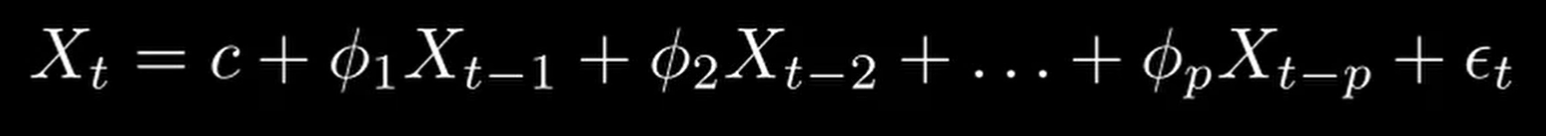

Les modèles autoregressifs fonctionne sur des données stationnaires. Pour cela on fait un test ADF (Augmented Dickey-Fuller).

p-value > 0.05: on ne peut pas rejeter l'hypothèse nulle, la série n'est pas stationnaire.

p-value < 0.05: on rejette l'hypothèse nulle, la série est stationnaire.

In [5]:
data = pd.read_parquet("C:\\Users\\tariq\\algorithmic_trading\\5min_perp\\BTC_USDT_USDT.parquet")
data["datetime"] = pd.to_datetime(data["date"])
data = data.set_index(['datetime'])

#logreturns
data['logreturns'] = np.log(data['close'] / data['close'].shift(1))
data.dropna(inplace=True)
data.head()

,date,open,high,low,close,volume,logreturns
datetime,,,,,,,
2020-01-01 00:05:00,2020-01-01 00:05:00,7174.71,7186.69,7173.28,7186.69,163.860,0.001593
2020-01-01 00:10:00,2020-01-01 00:10:00,7186.83,7188.10,7175.70,7176.26,290.358,-0.001452
2020-01-01 00:15:00,2020-01-01 00:15:00,7176.22,7179.41,7172.43,7173.68,189.617,-0.000360
2020-01-01 00:20:00,2020-01-01 00:20:00,7173.50,7176.13,7170.69,7171.81,198.838,-0.000261
2020-01-01 00:25:00,2020-01-01 00:25:00,7172.00,7179.04,7170.98,7172.36,319.378,0.000077


In [41]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/
    result = adfuller(series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

check_stationarity(data['logreturns'])


ADF Statistic: -75.224975
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


autre idées : bootstrapping, crossvalidating etc

In [6]:
train_size = 0.7
data_train = data.copy().iloc[:int(len(data) * train_size)]
data_test = data.copy().iloc[int(len(data) * train_size):]

corrélogramme, fonction d'autocorrélation partielle.

cela affiche l'autocorrélation entre les logreturn et les logreturns laggés.

l'autocorrélation partielle isole l'effet de la variable laggée sur la variable actuelle (contrairement a l'autocorrélation qui prend en compte toutes les variables laggées sans isolation).


,lag,PACF,lower_bounds,upper_bounds
1,1,-0.036858,-0.043116,-0.030599
2,2,-0.015998,-0.022257,-0.009740
3,3,0.013368,0.007109,0.019626
4,4,-0.008482,-0.014740,-0.002223
5,5,-0.023569,-0.029827,-0.017310
6,6,-0.021379,-0.027638,-0.015121
7,7,0.006596,0.000337,0.012854
11,11,0.008157,0.001898,0.014415
15,15,-0.009244,-0.015502,-0.002985
26,26,-0.006771,-0.013030,-0.000513


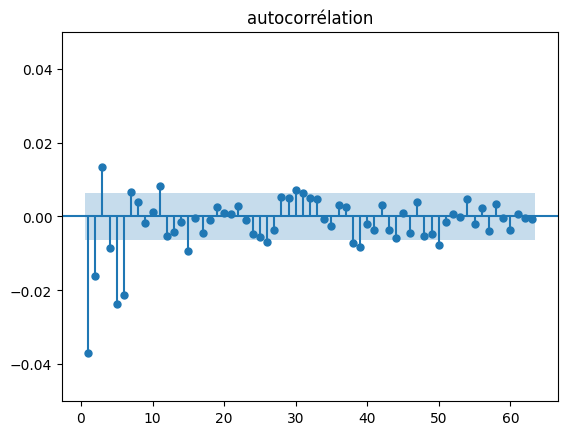

In [55]:
def compute_pacf(data, nlags, alpha): 
    serie = data["logreturns"]
    n = len(serie)
    z = norm.ppf(1 - alpha / 2)
    pacf_vals = pacf(serie, nlags=nlags, method="ywm") 
    #intervall de confiance
    conf_interval =  norm.ppf(1 - alpha / 2) / np.sqrt(n)
    lower_bounds = pacf_vals - conf_interval
    upper_bounds = pacf_vals + conf_interval

    significant = (pacf_vals < -conf_interval) | (pacf_vals > conf_interval)
    df = pd.DataFrame({
        "lag": range(len(pacf_vals)), 
        "PACF": pacf_vals,
        "lower_bounds": lower_bounds,
        "upper_bounds": upper_bounds
    })
    df_significant = df[significant & (df["lag"] != 0)]
    return df_significant

df_pacf = compute_pacf(data_train, nlags=50, alpha=0.0001)
display(df_pacf)

fix, ax = plt.subplots()
plot_pacf(data_train['logreturns'], lags=63, ax=ax, alpha=0.0001, use_vlines=True, method='ywm', title='autocorrélation', zero=False)
ax.set_ylim(-0.05, 0.05)
plt.show()

# Calcul des autocorrélation partielles pour toutes les paires

In [59]:
data_path = "C:\\Users\\tariq\\algorithmic_trading\\5min_perp"
file_list = os.listdir(data_path)

alpha = 0.0001
nlags = 10

df_pacfs = {}
for file in tqdm(file_list):
    if file.endswith("USDT.parquet"):
        crypto_name = file.split("_")[0]
        data = pd.read_parquet(os.path.join(data_path, file))
        data["datetime"] = pd.to_datetime(data["date"])
        data = data.set_index(['datetime'])
        data['logreturns'] = np.log(data['close'] / data['close'].shift(1))
        data.dropna(inplace=True)
        df_pacf = compute_pacf(data, nlags=nlags, alpha=alpha)
        df_pacfs[crypto_name] = df_pacf

100%|██████████| 450/450 [00:20<00:00, 21.54it/s]


In [104]:
all_pacf_data = []
for crypto_name, df_pacf in df_pacfs.items():
    df_pacf = df_pacf[(df_pacf["PACF"] < 0.5) & (df_pacf["PACF"] > -0.5)]    
    df_pacf["crypto"] = crypto_name    
    all_pacf_data.append(df_pacf)

big_pacf_df = pd.concat(all_pacf_data, ignore_index=True)
big_pacf_df = big_pacf_df[["crypto", "PACF", "lag"]]
big_pacf_df.sort_values(by=["PACF"], ascending=False)

,crypto,PACF,lag
1075,USDC,0.132834,1
230,BROCCOLI714,0.123280,2
462,FORM,0.098734,5
232,BROCCOLIF3B,0.089191,3
231,BROCCOLIF3B,0.079927,2
...,...,...,...
233,BROCCOLIF3B,-0.107186,6
1123,XEM,-0.135202,1
801,PAXG,-0.143395,1
99,ANIME,-0.163781,1


In [114]:
big_pacf_df.sort_values(by=["PACF"], ascending=True)

,crypto,PACF,lag
229,BROCCOLI714,-0.167986,1
99,ANIME,-0.163781,1
801,PAXG,-0.143395,1
1123,XEM,-0.135202,1
233,BROCCOLIF3B,-0.107186,6
...,...,...,...
231,BROCCOLIF3B,0.079927,2
232,BROCCOLIF3B,0.089191,3
462,FORM,0.098734,5
230,BROCCOLI714,0.123280,2


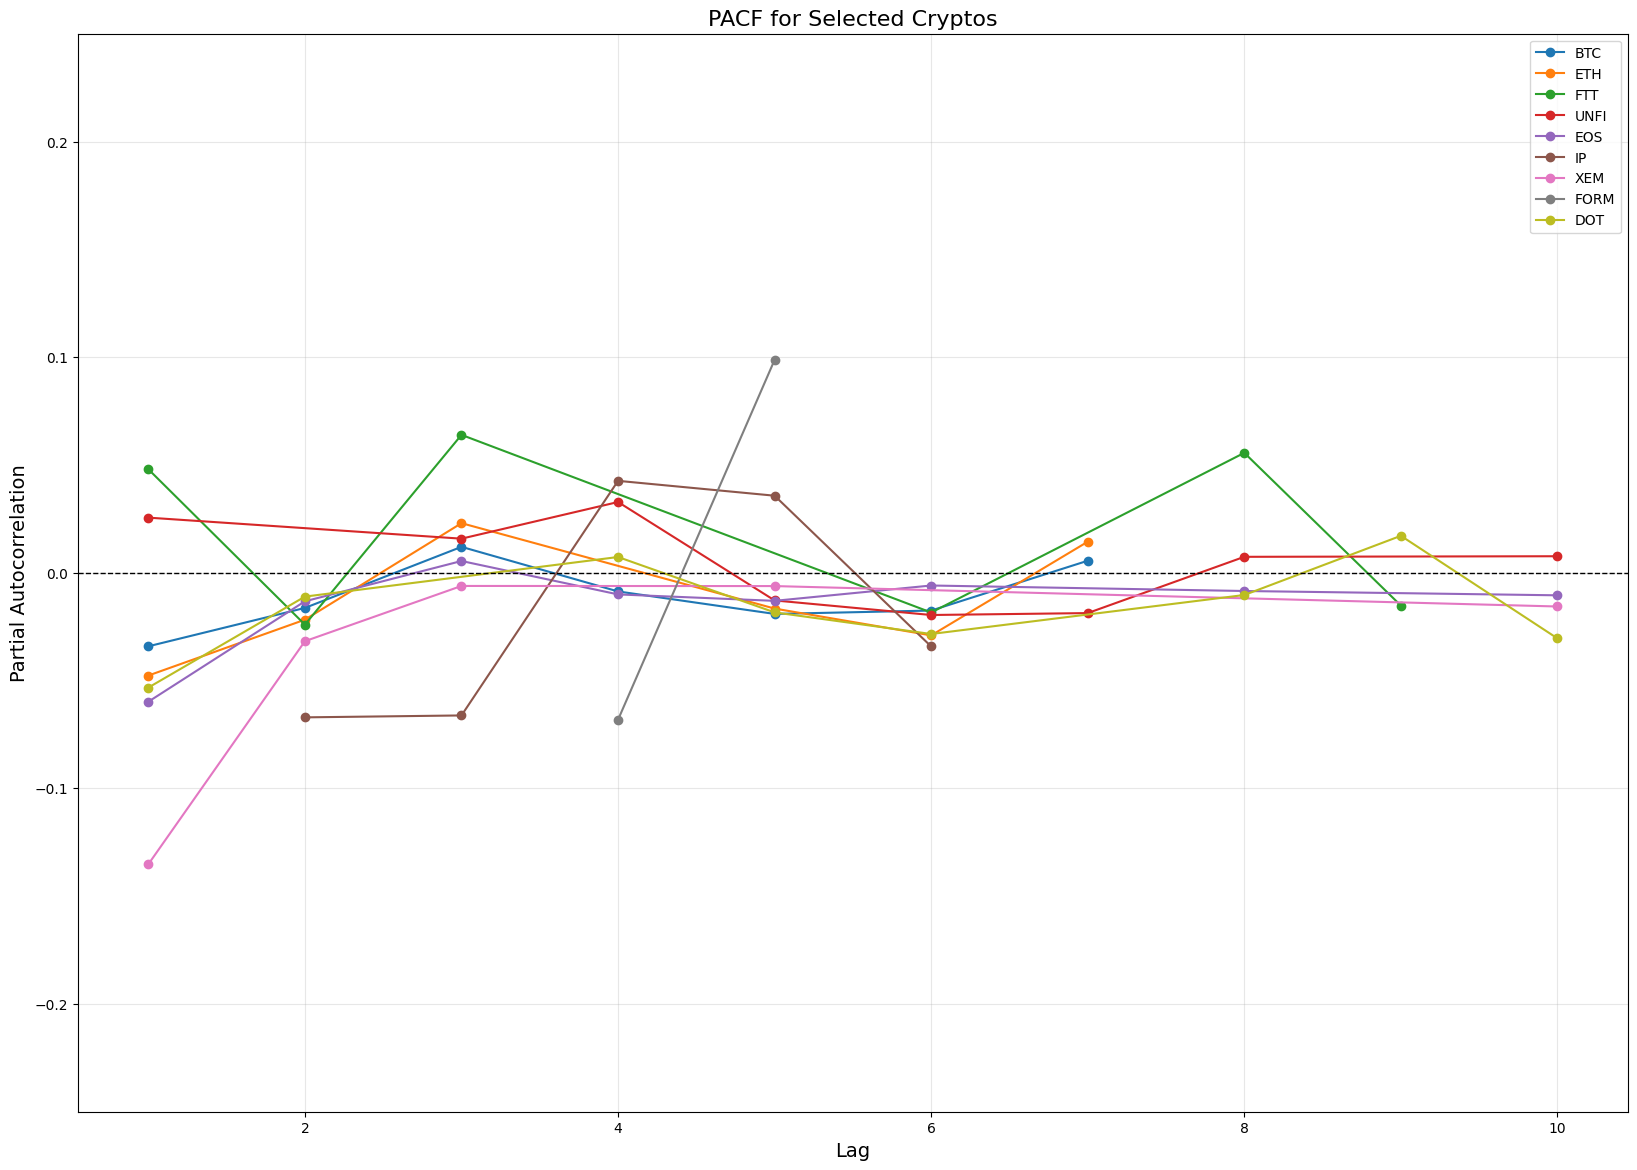

In [122]:
plot_pacf_lag(["BTC", "ETH", "FTT", "UNFI", 'EOS', 'IP', "XEM", "FORM", "DOT"], big_pacf_df)